In [7]:
import os 
import torch 
import numpy as np
from glob import glob
from tqdm.auto import tqdm

In [8]:
torch.cuda.is_available()

True

### Helper functions: 

In [9]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(LR_l, LR_r, SR_l, SR_r):
  h,w = SR_l.shape[:2]
  LR_l = cv2.resize(LR_l, (w,h), interpolation=cv2.INTER_CUBIC)
  LR_r = cv2.resize(LR_r, (w,h), interpolation=cv2.INTER_CUBIC)
  fig = plt.figure(figsize=(w//40, h//40))
  ax1 = fig.add_subplot(2, 2, 1) 
  plt.title('Input image (Left)', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(2, 2, 2)
  plt.title('NAFSSR output (Left)', fontsize=16)
  ax2.axis('off')
  ax1.imshow(LR_l)
  ax2.imshow(SR_l)

  ax3 = fig.add_subplot(2, 2, 3) 
  plt.title('Input image (Right)', fontsize=16)
  ax3.axis('off')
  ax4 = fig.add_subplot(2, 2, 4)
  plt.title('NAFSSR output (Right)', fontsize=16)
  ax4.axis('off')
  ax3.imshow(LR_r)
  ax4.imshow(SR_r)

  plt.subplots_adjust(wspace=0.04, hspace=0.04)

def stereo_image_inference(model, img_l, img_r, save_path):
      img = torch.cat([img_l, img_r], dim=0)
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      img_L = visuals['result'][:,:3]
      img_R = visuals['result'][:,3:]
      img_L, img_R = tensor2img([img_L, img_R])
      
      imwrite(img_L, save_path.format('L'))
      imwrite(img_R, save_path.format('R'))
    
      return img_L, img_R


In [10]:
opt_path = 'options/test/NAFSSR/NAFSSR-S_4x.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
print(opt['path']['pretrain_network_g'])
NAFSSR = create_model(opt)

/home/ubuntu/Documents/SR/sterioSR/NAFNet_v2/NAFNet/experiments/NAFNetSR-S_x4/models/net_g_360000.pth


2023-03-13 08:21:44,630 INFO: Loading NAFSSR model from /home/ubuntu/Documents/SR/sterioSR/NAFNet_v2/NAFNet/experiments/NAFNetSR-S_x4/models/net_g_360000.pth.
2023-03-13 08:21:44,741 INFO: Model [ImageRestorationModel] is created.


 load net keys <built-in method keys of collections.OrderedDict object at 0x7ffa360678c0>


In [11]:
validation_folder = '/home/ubuntu/Documents/SR/sterioSR/VAL_cvlai/LR_x4' 
val_images = sorted(glob(f'{validation_folder}/*.png'))

In [12]:
# for im im val_images:
N = 112
iterations = 360000
left_image = '{}/'
for i in tqdm(range(1,N+1)): 
    image_num = f'0000{i}'[-4:]
    left_image = f'{validation_folder}/{image_num}_L.png' 
    right_image = f'{validation_folder}/{image_num}_R.png'
#     print(left_image, right_image)
    
    # print(image_num)
    output_path = f'/home/ubuntu/Documents/SR/sterioSR/Output_Folder/exp3/{iterations}/'+image_num+'_{}.png' 
    
    img_l = imread(left_image) 
    inp_l = img2tensor(img_l) 
    img_r = imread(right_image) 
    inp_r = img2tensor(img_r)  
    _,_ = stereo_image_inference(NAFSSR, inp_l, inp_r, output_path)

100%|██████████| 112/112 [00:42<00:00,  2.62it/s]


In [33]:
path = %pwd
%cd /home/ubuntu/Documents/SR/sterioSR/Output_Folder/exp3/{iterations}/
log = !zip val_output_{iterations}_l1_percp_text.zip *.png
%cd {path}

/home/ubuntu/Documents/SR/sterioSR/Output_Folder/exp3/320000
/home/ubuntu/Documents/SR/sterioSR/NAFNet_v2/NAFNet


: 

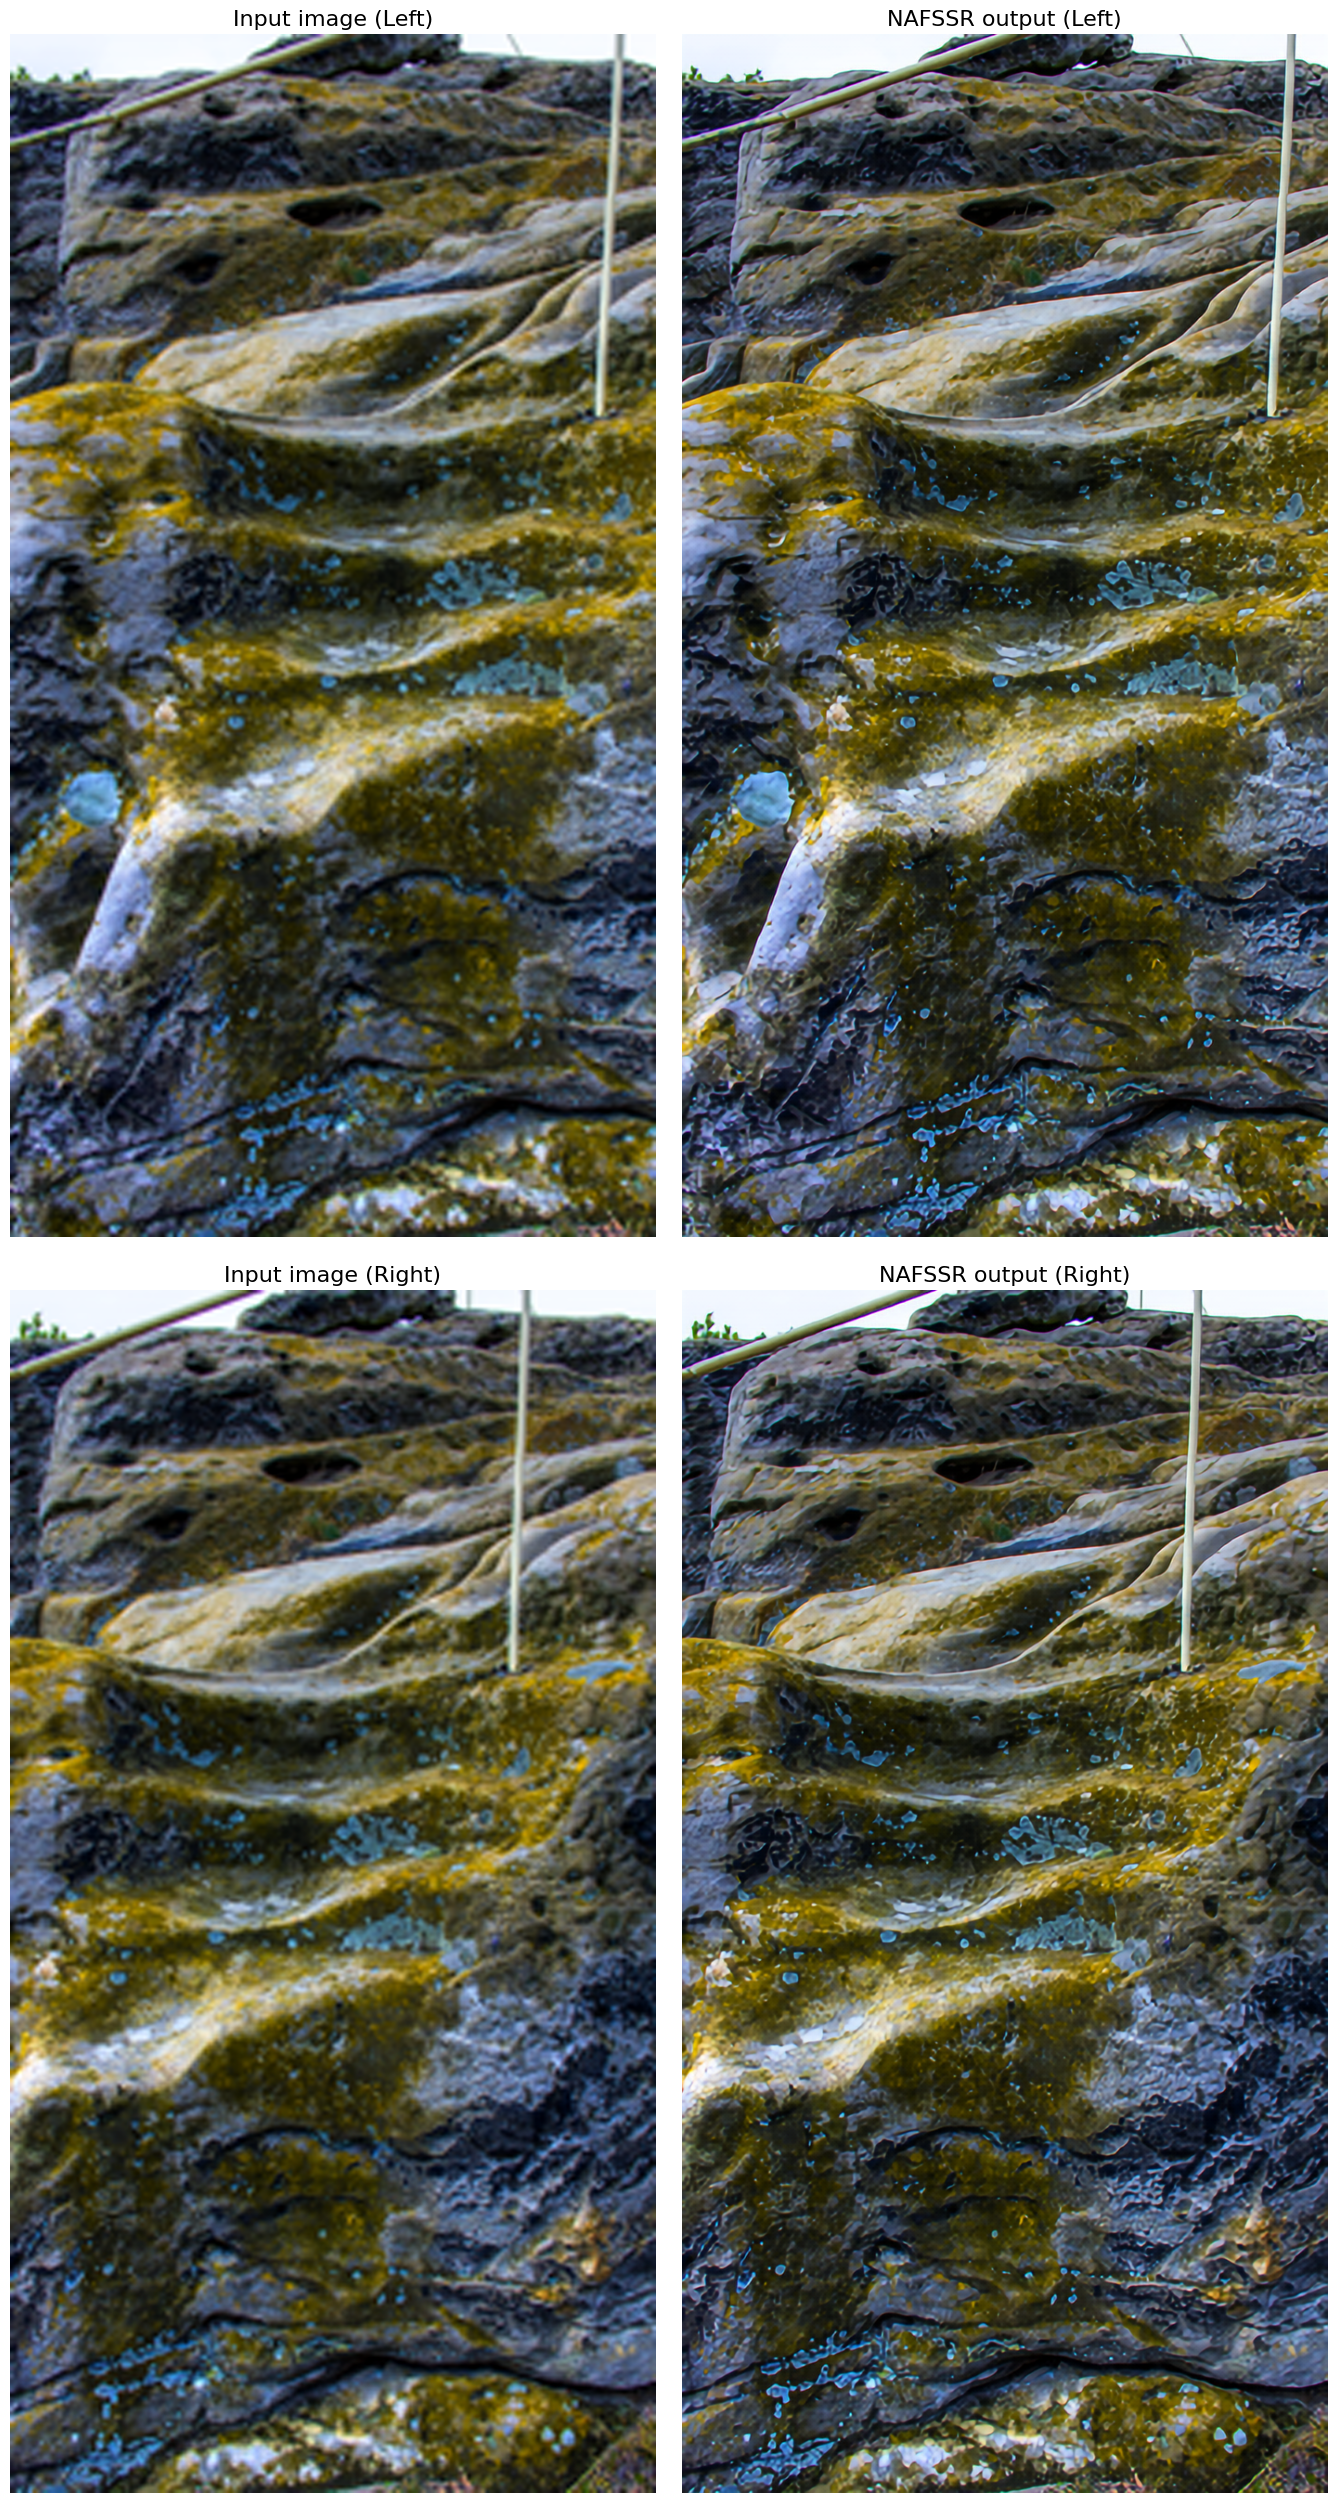

In [29]:
i = 56
left_image, right_image = val_images[i], val_images[i+1]
output_path = f'/home/ubuntu/Documents/SR/sterioSR/Output_Folder/exp3/{iterations}/' + 'i_{}_sr.png'
img_l = imread(left_image) 
inp_l = img2tensor(img_l) 
img_r = imread(right_image) 
inp_r = img2tensor(img_r)  
sr_l, sr_r = stereo_image_inference(NAFSSR, inp_l, inp_r, output_path)
sr_l = imread(output_path.format('L'))
sr_r = imread(output_path.format('R'))
display(img_l, img_r, sr_l, sr_r)

In [9]:
sr_l.shape, img_l.shape

((1296, 696, 3), (324, 174, 3))

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# read the input image
# img = cv2.imread('film.jpg',0)
img = sr_l

# find the discrete fourier transform of the image
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)

# hift zero-frequency component to the center of the spectrum
dft_shift = np.fft.fftshift(dft)
rows, cols = img.shape
crow,ccol = rows//2 , cols//2
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

# visualize the images
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()